In [1]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt
import os
import re
from numpy import linalg as LA
from collections import defaultdict

In [2]:
# construct dataset 

In [3]:
data_path = 'p2_data'

In [4]:
train_set = {}
test_set = {}

for i in range(1, 41):
    train_set[i] = {}
    test_set[i] = {}

In [5]:
for file in os.listdir(data_path):
    person_index = int(re.split('[_.]', file)[0])
    sample_index = int(re.split('[_.]', file)[1])
    fullpath = os.path.join(data_path, file)

    if os.path.isfile(fullpath):
        img = cv2.imread(fullpath, cv2.IMREAD_GRAYSCALE)
        if sample_index==10:
            test_set[person_index][sample_index] = img
        else:
            train_set[person_index][sample_index] = img
            

In [6]:
# PCA
def PCA(train_set):
    # basic info
    num_people = len(train_set)
    num_sample = len(train_set[1])
    H, W = train_set[1][1].shape[0], train_set[1][1].shape[1]
    
    # stacking imgs
    samples = []
    for i in range(1, num_people+1):
        for j in range(1, num_sample+1):
            samples.append(train_set[i][j])
    stacked_samples = np.stack(samples, axis=0)    # 360 56 46
    
    # calculate corvariance matrix
    avg_samples = np.expand_dims(np.sum(stacked_samples, axis=0) / (num_people*num_sample), axis=0)  # 1 56 46
    nor_samples = (stacked_samples - avg_samples).reshape(num_people*num_sample, H*W)                # 360 56*46
    cor_mtx = np.matmul(nor_samples.T, nor_samples) / (num_people*num_sample)
    
    # calculate eigen vector and eigen value
    w, v = LA.eig(cor_mtx)
    eigen_sort = list(np.argsort(w))[::-1]
    sorted_w = w[eigen_sort]
    sorted_v = v[:, eigen_sort]
    
    return sorted_w, sorted_v, avg_samples

In [7]:
def eigenface(face, mean, eigen_vec, n):
    # basic info & preprocess
    H, W = face.shape[0], face.shape[1]
    face, mean = face.reshape(-1,1), mean.reshape(-1,1)
    
    used_vec = eigen_vec[:,:n]              # shape=(d, n)
    A = np.matmul(used_vec.T, face-mean)
    recon_face = np.matmul(used_vec, A).reshape(H, W)
    
    return recon_face

In [8]:
def MSE(recon_img, target):
    return np.sum((recon_img-target) * (recon_img-target)) / (target.shape[0] * target.shape[1])

In [9]:
def projection(faces, mean, eigen_vec, n):
    # basic info
    H, W = faces[0].shape[0], faces[0].shape[1]
    
    stacked_face = np.empty((len(faces), H*W))   # shape=(N, d)
    for i in range(len(faces)):
        stacked_face[i] = faces[i].reshape(-1)
    
    # projection
    mean = mean.reshape(1,-1)         # shape=(1, d)
    used_vec = eigen_vec[:,:n]        # shape=(d, n)
    A = np.matmul(stacked_face-mean, used_vec) # shape=(N, n)
    
    return A    

In [10]:
def acc(pre, tar):
    return np.sum(pre==tar)/len(pre)

In [11]:
eigen_value, eigen_vector, mean = PCA(train_set)

In [12]:
print(eigen_vector[:, 0].astype(np.float))

[0.00606884 0.00622373 0.00559664 ... 0.015444   0.01280517 0.01320866]


/home/zxcvbn7222/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


Mean:


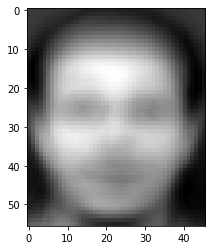

Eigen face: 0


/home/zxcvbn7222/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


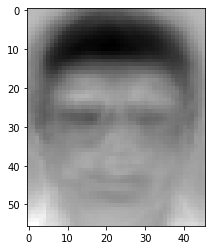

Eigen face: 1


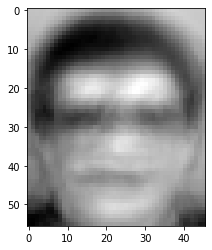

Eigen face: 2


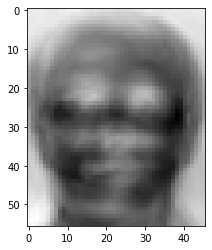

Eigen face: 3


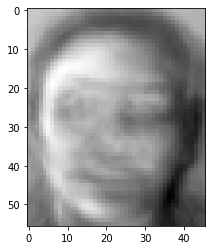

In [13]:
# 2-1
H, W = 56, 46

# mean
print('Mean:')
plt.imshow(mean.reshape(H, W), cmap='gray')
plt.show()

# eigen face
for i in range(4):
    print(f"Eigen face: {i}")
    plt.imshow(eigen_vector[:, i].reshape(H, W).astype(np.float), cmap='gray')
    plt.show()

In [14]:
print(mean.shape)
print(train_set[2][1].shape)
print(eigen_vector.shape)

(1, 56, 46)
(56, 46)
(2576, 2576)


n=3:  99.6207298136646


/home/zxcvbn7222/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


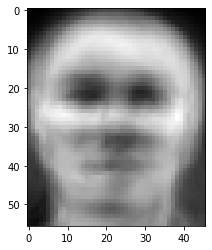

n=50:  100.71855590062111


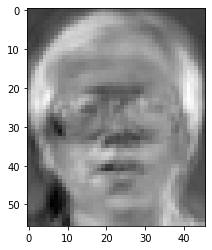

n=170:  97.38975155279503


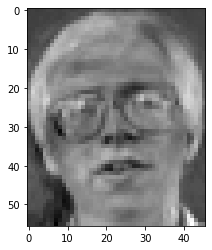

n=240:  98.84006211180125


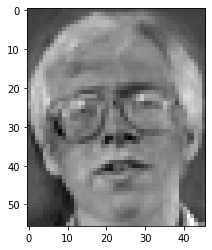

n=345:  99.02950310559007


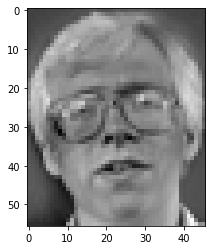

In [15]:
# 2-2 & 2-3
test_list = [3, 50, 170, 240, 345]
for n in test_list:
    result = eigenface(train_set[2][1], mean, eigen_vector, n).astype(np.float)
    mse = MSE(result, train_set[2][1])
    print(f"n={n}: ",mse)
    plt.imshow(result, cmap='gray')
    plt.show()

In [16]:
def k_nearest(k, train, val, train_labels, val_labels):
    prediction = np.empty((val.shape[0]))
    
    for i in range(val.shape[0]):
        distance = np.sum(np.square(val[i].reshape(1,-1) - train), axis=1)   # num_train_sample * 1
        first_k_labels = train_labels[np.argsort(distance, axis=0)[:k]].astype(np.int)   
        prediction[i] = np.argmax(np.bincount(first_k_labels))
    
    return acc(prediction, val_labels) 

In [17]:
# 2-4
k_list = [1,3,5]
n_list = [3, 50, 170]
valid_list = [0,1,2]

acc_record = defaultdict(list)
for valid_index in valid_list:
    
    # construct training set and vlidation set of cross-validation   
    train_faces = []
    val_faces = []
    train_labels = np.empty((240))
    val_labels = np.empty((120))
    
    valid_sample = list(range(1+3*valid_index, 4+3*valid_index))
    
    train_counter = 0
    val_counter = 0
    for sample in range(1, 10):
        if sample in valid_sample:
            for j in range(1, len(train_set)+1):
                val_faces.append(train_set[j][sample])
                val_labels[val_counter] = j
                val_counter+=1
        else:
            for j in range(1, len(train_set)+1):
                train_faces.append(train_set[j][sample])
                train_labels[train_counter] = j
                train_counter+=1
    #print(val_labels)
    
    # k-nearest
    for k in k_list:
        for n in n_list:
            train = projection(train_faces, mean, eigen_vector, n)
            val = projection(val_faces, mean, eigen_vector, n)

            acc_record[(k, n)].append(k_nearest(k, train, val, train_labels, val_labels))
    
temp_max = 0
best_setting = None

for key in acc_record.keys():
    print(key, sum(acc_record[key])/3)
    if sum(acc_record[key])>temp_max:
        temp_max = sum(acc_record[key])
        best_setting = key
print(best_setting)

(1, 3) 0.65
(1, 50) 0.9611111111111111
(1, 170) 0.9555555555555556
(3, 3) 0.6111111111111112
(3, 50) 0.9
(3, 170) 0.8888888888888888
(5, 3) 0.5611111111111111
(5, 50) 0.8472222222222222
(5, 170) 0.8222222222222223
(1, 50)


In [18]:
# 2-5
train_faces = []
test_faces = []
train_labels = np.empty((360))
test_labels = np.empty((40))
    
train_counter = 0
for sample in range(1, 10):
    for j in range(1, len(train_set)+1):
        train_faces.append(train_set[j][sample])
        train_labels[train_counter] = j
        train_counter+=1

test_counter = 0
for j in range(1, len(test_set)+1):
    test_faces.append(test_set[j][10])
    test_labels[test_counter] = j
    test_counter+=1

train = projection(train_faces, mean, eigen_vector, 50)
test = projection(test_faces, mean, eigen_vector, 50)
print(k_nearest(1, train, test, train_labels, test_labels))

0.925
